# Figure in the introduction about emitting spot size vs output and colored by imaging time

In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from itertools import product
import seaborn as sns
%matplotlib inline

In [2]:
# range of parameters to calculate for
ni = 100 # number of intervals to sample in emitting spot and source strength

f_min = 0.5 # lower limit of emitting spot to use, mm
f_max = 26 # upper limit of emitting spot to use, mm
di = (f_max-f_min)/ni
f_list = np.arange(f_min, f_max+di, di) # focal spot, mm, over a range of f_min to f_max

e_min = 7.5 # lower limit of neutron output 1eX n/s
e_max = 12.5 # upper limit of neutron output 1eX n/s
di = (e_max-e_min)/ni
exp_list = np.arange(e_min, e_max+di, di) # use outputs of e_min to e_max in steps of ni
if len(exp_list) > len(f_list): exp_list = np.delete(exp_list, -1)
o_list = np.asarray([10**e for e in exp_list]) # calculates output (neutrons/s) based on given exponent

In [3]:
def numpy_get_optimum_geometry(
    output, # calculates output (neutrons/s) based on given exponent (this is o_list)
    f, # focal spot, mm
    output_bias, # forward bias of output, for DD reaction, approx. vs. isotropic
    d_so_min, # source object minimum distance, mm
    d_od_min, # object detector minimum distance, mm
    d_sd_max, # source detector maximum distance, mm
    d_so_max, # source object maximum distance, mm
    d_sd_ndar, # source detector distance, mm, numpy array
    d_so_ndar, # source object distance, mm, numpy array
    M_ndar, # magnification
    FOV_min, # field of view required to be satisfied
    det_size_max, # maximum detector size
    B_d, # assumed detector resolution, mm
    resolution_goal, # target overall maximum allowed resolution, mm
    detector_efficiency, # assumed detector efficiency
    detector_counts):# required flat field counts per pixel for an image, [-]
    

    B_do_nd = np.empty((M_ndar.shape[0],M_ndar.shape[1]),dtype='float64')
    B_do_nd = np.true_divide(B_d, M_ndar)

    B_fo_nd = np.empty((M_ndar.shape[0],M_ndar.shape[1]),dtype='float64')
    B_fo_nd = f * (1-(np.true_divide(1, M_ndar)))
 
    B_o_nd = np.empty((M_ndar.shape[0],M_ndar.shape[1]),dtype='float64')
    B_o_nd = np.sqrt(B_do_nd**2 + B_fo_nd**2)
    
    imaging_time_effective_nd = np.empty((M_ndar.shape[0],M_ndar.shape[1]),dtype='float64')
    imaging_time_effective_nd = 4*np.pi*(d_so_ndar**2)*detector_counts/(resolution_goal**2)/output/output_bias/detector_efficiency
#     print(pd.DataFrame(imaging_time_effective_nd))
    
    d_od_ndar = np.empty((M_ndar.shape[0],M_ndar.shape[1]),dtype='float64')
    d_od_ndar = d_sd_ndar - d_so_ndar
    forbidden_d_od_ndar = d_od_ndar < d_od_min
    
    M_max = det_size_max/FOV_min # maximum allowed magnification
    forbidden_M_ndar = np.zeros((M_ndar.shape[0],M_ndar.shape[1]))
    forbidden_M_ndar = M_ndar > M_max
    
    forbidden_B_o_nd= np.zeros((M_ndar.shape[0],M_ndar.shape[1]))
    forbidden_B_o_nd = B_o_nd > resolution_goal
    
    forbidden_ndar = forbidden_M_ndar | forbidden_B_o_nd | forbidden_d_od_ndar
    
    imaging_time_effective_nd[forbidden_ndar] = 1e10

    best_imaging_time = np.min(imaging_time_effective_nd)
#     print(best_imaging_time)
    loc = np.argwhere(imaging_time_effective_nd==best_imaging_time)

    best_d_so = d_so_ndar[:,0][loc[0][0]]
    best_d_sd = d_sd_ndar[0,loc[0][1]]
#     print(best_d_sd)
#     print(best_d_so)

    return pd.Series([best_imaging_time, best_d_so, best_d_sd], index=['best_imaging_time', 'best_d_so', 'best_d_sd'])


In [4]:
def do_run(run,
        d_so_min, # source object minimum distance, mm
        d_sd_min, # source detector minimum distance, mm
        d_od_min, # object detector minimum distance, mm
        d_sd_max, # source detector maximum distance, mm
        d_so_max, # source object maximum distance, mm
        FOV_min, # field of view (degree) required to be satisfied, mm, max size the object can have in the cone
        det_size_max, # maximum detector size, mm lenght of the detector
        B_d, # assumed detector resolution, mm
        resolution_goal, # target overall maximum allowed resolution, mm
        detector_efficiency, # assumed detector efficiency, [-]
        detector_counts, # required flat field counts per pixel for an image, [-]
        output_bias): # forward bias of output, for DD reaction, approx. vs. isotropic):
    data = pd.DataFrame()


    ni = 5 # number of options in each d_sd and d_so
    d_so_ar = np.arange(d_so_min,d_so_max+ni, ni) # Roberts data
    # d_so_ar = np.linspace(d_so_min,d_so_max, ni) # Roberts data

    ni = 5 # number of options in each d_sd and d_so
    d_sd_ar = np.arange(d_so_min,d_sd_max+ni, ni) # Roberts data
    # d_sd_ar = np.linspace(d_sd_min,d_sd_max, ni) # Roberts data

    d_so_ndar = np.empty((d_so_ar.shape[0],d_sd_ar.shape[0]))
    d_sd_ndar = np.empty((d_so_ar.shape[0],d_sd_ar.shape[0]))

    d_so_ndar = np.tile(d_so_ar, (d_sd_ar.shape[0],1)).T
    d_sd_ndar = np.tile(d_sd_ar, (d_so_ar.shape[0],1))

    # magnification
    M_ndar = np.empty((d_so_ar.shape[0],d_sd_ar.shape[0]))
    M_ndar = d_sd_ndar/d_so_ndar
    kk = 0
    start_time = time.time()
    for ii in range(0,len(f_list)):
        # test for the first ten entries
        for jj in range(0,len(o_list)):
            if kk % 1000 == 0: 
                print(f'Done {kk}')
            kk = kk + 1
            f = f_list[ii]
            output = o_list[jj]
            exp = exp_list[jj]
            s = numpy_get_optimum_geometry(
                output, # calculates output (neutrons/s) based on given exponent (this is o_list)
                f, # focal spot, mm
                output_bias, # forward bias of output, for DD reaction, approx. vs. isotropic
                d_so_min, # source object minimum distance, mm
                d_od_min, # object detector minimum distance, mm
                d_sd_max, # source detector maximum distance, mm
                d_so_max, # source object maximum distance, mm
                d_sd_ndar, # source detector distance, mm, numpy array
                d_so_ndar, # source object distance, mm, numpy array
                M_ndar, # magnification
                FOV_min, # field of view required to be satisfied
                det_size_max, # maximum detector size
                B_d, # assumed detector resolution, mm
                resolution_goal, # target overall maximum allowed resolution, mm
                detector_efficiency, # assumed detector efficiency
                detector_counts)# required flat field counts per pixel for an image, [-]


            s['f'] = f
            s['exp'] = exp
            s['output'] = output
            this_data = pd.DataFrame(s)
            data = data.append(this_data.T) 

    duration = (time.time() - start_time)
    print("--- %s seconds ---" % duration)

    data_plot = pd.pivot_table(data, values='best_imaging_time', index='f', columns='exp')
    data_plot[data_plot < 0.05] = np.nan # cutoff very fast imaging times
    data_plot = data_plot / 60 # convert to hours
    data_plot[data_plot > 100] = np.nan # cutoff 100 minutes
    do_plot(data_plot, run)

In [5]:
def do_plot(data_plot, run):
    from matplotlib.colors import LogNorm
    import math 
    import os
    import matplotlib
    import matplotlib.ticker as ticker
    os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2018/bin/x86_64-darwin'
    plt.rc('text', usetex=True)
    plt.rc('font', weight='bold')
    matplotlib.rcParams["font.weight"] = "bold"
    matplotlib.rcParams["axes.labelweight"] = "bold"
    matplotlib.rcParams['mathtext.fontset'] = 'custom'
    matplotlib.rcParams['mathtext.rm'] = 'Arial'
    matplotlib.rcParams['mathtext.it'] = 'Arial:italic'
    matplotlib.rcParams['mathtext.bf'] = 'Arial:bold'
    matplotlib.rcParams['mathtext.tt'] = 'Arial'
    matplotlib.rcParams['mathtext.cal'] = 'Arial'
    matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']
    outfile = '/Users/hkromer/02_PhD/02_Data/10.OutputVSEmittingSpot_Robert/my_plots/'

    outfile = f"{outfile}{run}.pdf"
    fig = plt.figure(figsize=(8, 6))
    num_ticks = 10
    fs = 20
    # ylabels
    # the index of the position of yticks
    ylabels = data_plot.index.values
    yticks = np.linspace(0, len(ylabels) - 1, num_ticks, dtype=np.int)
    # the content of labels of these yticks
    yticklabels = [np.round(ylabels[idx], 0) for idx in yticks]

    # xlabels
    # # the index of the position of xticks
    xlabels = data_plot.columns.values
    xlabels = np.round(xlabels, 2)
    # xticks = np.linspace(0, len(xlabels) - 1, num_ticks, dtype=np.int)
    # # the content of labels of these yticks
    # xticklabels = [np.round(xlabels[idx], 1) for idx in xticks]
    # print(xticks, xticklabels)
    xticklabels = np.arange(xlabels[0],xlabels[-1]+0.5, 0.5)
    xticks = np.asarray([])
    for ii in range(0,len(xticklabels)):
        for jj in range(0,len(xlabels)):
            if xticklabels[ii] == xlabels[jj]:
                xticks = np.append(xticks, jj)
    xticks = xticks.astype(int)
    assert xticklabels.all() == xlabels[xticks].all()

    log_norm = LogNorm(vmin=data_plot.min().min(), vmax=data_plot.max().max())
    cbar_ticks = [math.pow(10, i) for i in range(math.floor(math.log10(data_plot.min().min())), 1+math.ceil(math.log10(data_plot.max().max())))]

    # cbar_ticks = [0,1,10,1e2,1e3,1e4,1e5]
    # sns.set(font_scale = 2)
    sns.set_context("paper")
    sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white',"xtick.bottom" : True, "ytick.left" : True, 'font.weight': "bold"})

#     ax = sns.heatmap(data_plot, yticklabels=yticklabels, xticklabels=xticklabels, vmax=101, cmap='coolwarm', norm=log_norm, cbar_kws={"ticks": cbar_ticks})
    ax = sns.heatmap(data_plot, yticklabels=yticklabels, xticklabels=xticklabels, vmax=101, cmap='rainbow', norm=log_norm, cbar_kws={"ticks": cbar_ticks})

    # ax.xaxis.set_major_formatter(ticker.EngFormatter())
    ax.set_yticks(yticks)
    ax.set_xticks(xticks)
    ax.invert_yaxis()
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=fs-2) 
    for label in ax.get_yticklabels():
        label.set_size(fs-2)
        label.set_weight("heavy")
    #     label.set_color("black")
    for label in ax.get_xticklabels():
        label.set_size(fs-2)
        label.set_weight("heavy")
    #     label.set_color("black")
    # ax.tick_params('x', colors='black', labelsize=fs-2)
    # ax.tick_params('y', colors='black', labelsize=fs-2)
    plt.xlabel(r'\textbf{x, where neutron output} $10^x$ \textbf{neutrons/s}', fontsize=fs)
    cbar.ax.set_ylabel(r'\textbf{Time per radiograph [min]}', rotation=90)
    plt.ylabel(r'\textbf{Emitting spot size [mm]}', fontsize=fs)
    plt.yticks(rotation=0) 
    plt.xticks(rotation=0) 
    plt.tight_layout()
    plt.savefig(outfile)
    plt.show()

In [6]:
# model assumptions
run = 1
d_so_min = 100 # source object minimum distance, mm
d_sd_min = 100 # source detector minimum distance, mm
d_od_min = 100 # object detector minimum distance, mm
d_sd_max = 10000 # source detector maximum distance, mm
d_so_max = 10000 # source object maximum distance, mm
FOV_min = 200 # field of view (degree) required to be satisfied, mm, max size the object can have in the cone
det_size_max = 1000 # maximum detector size, mm lenght of the detector
B_d = 0.8 # assumed detector resolution, mm
resolution_goal = 1.2 # target overall maximum allowed resolution, mm
detector_efficiency = 0.05 # assumed detector efficiency, [-]
detector_counts = 3000 # required flat field counts per pixel for an image, [-]
output_bias = 2 # forward bias of output, for DD reaction, approx. vs. isotropic

In [7]:
d_so_mins = pd.Series([50, 100, 200], name='d_so_min')
d_sd_mins = pd.Series([50, 100, 200], name='d_sd_min')
d_od_mins = pd.Series([50, 100, 200], name='d_od_min')
d_sd_maxs = pd.Series([500, 10000, 20000], name='d_sd_max')
d_so_maxs = pd.Series([500, 10000, 20000], name='d_so_max')
FOV_mins = pd.Series([100, 200, 400], name='FOV_min')
det_size_maxs = pd.Series([500, 1000, 2000], name='det_size_max')
B_ds = pd.Series([0.4, 0.8, 1.6], name='B_d')
resolution_goals = pd.Series([0.6, 1.2, 2.4], name='resolution_goal')
detector_efficiencys = pd.Series([0.025, 0.05, 0.1], name='detector_efficiency')
detector_countss = pd.Series([1500, 3000, 6000], name='detector_counts')
series = [d_so_mins, d_sd_mins, d_od_mins, d_sd_maxs, d_so_maxs, FOV_mins, det_size_maxs, B_ds,resolution_goals, detector_efficiencys, detector_countss ]
df = pd.concat(series, axis=1)
for val in df.loc[:,'det_size_max']:
    print(val)
# df

500
1000
2000


In [8]:
df_runs = pd.DataFrame(columns=df.columns)

# col = 'd_sd_min'
# cols = df.columns.tolist()
# cols.remove(col)
# s = df.loc[1,cols]
# s[col] = np.nan
# df2 = pd.DataFrame([s])
# df_runs = df_runs.append(df2)

# col = 'resolution_goal'
# cols = df.columns.tolist()
# cols.remove(col)
# s = df.loc[1,cols]
# s[col] = np.nan
# df2 = pd.DataFrame([s])
# df_runs = df_runs.append(df2)

for col in df.columns:
    for val in df.loc[:,col]:
        cols = df.columns.tolist()
        cols.remove(col)
        s = df.loc[1,cols]
        s[col] = val
        df2 = pd.DataFrame([s])
        df_runs = df_runs.append(df2)

df_runs=df_runs.reset_index(drop=True)
dupl_index = df_runs[df_runs.duplicated()].index.values # show duplicates
# print(dupl_index)
# print(len(df_runs))
df_runs = df_runs.drop_duplicates(keep='first')
df_runs = df_runs.reset_index(drop=True)
# print(len(df_runs))
df_runs['run'] = df_runs.index+1
df_runs

/Users/hkromer/anaconda3/envs/py3.7/lib/python3.7/site-packages/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


,B_d,FOV_min,d_od_min,d_sd_max,d_sd_min,d_so_max,d_so_min,det_size_max,detector_counts,detector_efficiency,resolution_goal,run
0,0.8,200.0,100.0,10000.0,100.0,10000.0,50.0,1000.0,3000.0,0.050,1.2,1
1,0.8,200.0,100.0,10000.0,100.0,10000.0,100.0,1000.0,3000.0,0.050,1.2,2
2,0.8,200.0,100.0,10000.0,100.0,10000.0,200.0,1000.0,3000.0,0.050,1.2,3
3,0.8,200.0,100.0,10000.0,50.0,10000.0,100.0,1000.0,3000.0,0.050,1.2,4
4,0.8,200.0,100.0,10000.0,200.0,10000.0,100.0,1000.0,3000.0,0.050,1.2,5
5,0.8,200.0,50.0,10000.0,100.0,10000.0,100.0,1000.0,3000.0,0.050,1.2,6
6,0.8,200.0,200.0,10000.0,100.0,10000.0,100.0,1000.0,3000.0,0.050,1.2,7
7,0.8,200.0,100.0,500.0,100.0,10000.0,100.0,1000.0,3000.0,0.050,1.2,8
8,0.8,200.0,100.0,20000.0,100.0,10000.0,100.0,1000.0,3000.0,0.050,1.2,9
9,0.8,200.0,100.0,10000.0,100.0,500.0,100.0,1000.0,3000.0,0.050,1.2,10


# Do the simulation and plot for one set of parameters
## For the plot in the introduction

In [12]:
def do_plot_thesis(data_plot, run, outfile):
    from matplotlib.colors import LogNorm
    import math 
    import os
    import matplotlib
    import matplotlib.ticker as ticker
    os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2018/bin/x86_64-darwin'
    plt.rc('text', usetex=True)
    plt.rc('font', weight='bold')
    matplotlib.rcParams["font.weight"] = "bold"
    matplotlib.rcParams["axes.labelweight"] = "bold"
    matplotlib.rcParams['mathtext.fontset'] = 'custom'
    matplotlib.rcParams['mathtext.rm'] = 'Arial'
    matplotlib.rcParams['mathtext.it'] = 'Arial:italic'
    matplotlib.rcParams['mathtext.bf'] = 'Arial:bold'
    matplotlib.rcParams['mathtext.tt'] = 'Arial'
    matplotlib.rcParams['mathtext.cal'] = 'Arial'
    matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']
#     outfile = '/Users/hkromer/02_PhD/02_Data/10.OutputVSEmittingSpot_Robert/my_plots/'

#     outfile = f"{outfile}{run}.pdf"
    fig = plt.figure(figsize=(8, 6))
    num_ticks = 10
    fs = 20
    # ylabels
    # the index of the position of yticks
    ylabels = data_plot.index.values
    yticks = np.linspace(0, len(ylabels) - 1, num_ticks, dtype=np.int)
    # the content of labels of these yticks
    yticklabels = [np.round(ylabels[idx], 0) for idx in yticks]

    # xlabels
    # # the index of the position of xticks
    xlabels = data_plot.columns.values
    xlabels = np.round(xlabels, 2)
    # xticks = np.linspace(0, len(xlabels) - 1, num_ticks, dtype=np.int)
    # # the content of labels of these yticks
    # xticklabels = [np.round(xlabels[idx], 1) for idx in xticks]
    # print(xticks, xticklabels)
    xticklabels = np.arange(xlabels[0],xlabels[-1]+0.5, 0.5)
    xticks = np.asarray([])
    for ii in range(0,len(xticklabels)):
        for jj in range(0,len(xlabels)):
            if xticklabels[ii] == xlabels[jj]:
                xticks = np.append(xticks, jj)
    xticks = xticks.astype(int)
    assert xticklabels.all() == xlabels[xticks].all()

    log_norm = LogNorm(vmin=data_plot.min().min(), vmax=data_plot.max().max())
    cbar_ticks = [math.pow(10, i) for i in range(math.floor(math.log10(data_plot.min().min())), 1+math.ceil(math.log10(data_plot.max().max())))]

    # cbar_ticks = [0,1,10,1e2,1e3,1e4,1e5]
    # sns.set(font_scale = 2)
    sns.set_context("paper")
    sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white',"xtick.bottom" : True, "ytick.left" : True, 'font.weight': "bold"})

#     ax = sns.heatmap(data_plot, yticklabels=yticklabels, xticklabels=xticklabels, vmax=101, cmap='coolwarm', norm=log_norm, cbar_kws={"ticks": cbar_ticks})
    ax = sns.heatmap(data_plot, yticklabels=yticklabels, xticklabels=xticklabels, vmax=101, cmap='rainbow', norm=log_norm, cbar_kws={"ticks": cbar_ticks})

    # ax.xaxis.set_major_formatter(ticker.EngFormatter())
    ax.set_yticks(yticks)
    ax.set_xticks(xticks)
    ax.invert_yaxis()
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=fs-2) 
    for label in ax.get_yticklabels():
        label.set_size(fs-2)
        label.set_weight("heavy")
    #     label.set_color("black")
    for label in ax.get_xticklabels():
        label.set_size(fs-2)
        label.set_weight("heavy")
    #     label.set_color("black")
    # ax.tick_params('x', colors='black', labelsize=fs-2)
    # ax.tick_params('y', colors='black', labelsize=fs-2)
    plt.xlabel(r'\textbf{x, where neutron output} $10^x$ \textbf{neutrons/s}', fontsize=fs)
    cbar.ax.set_ylabel(r'\textbf{Time per radiograph [min]}', rotation=90)
    plt.ylabel(r'\textbf{Emitting spot size [mm]}', fontsize=fs)
    plt.yticks(rotation=0) 
    plt.xticks(rotation=0) 
    plt.tight_layout()
    plt.savefig(outfile)
    plt.show()

In [13]:
def do_run_thesis(outfile, run,
        d_so_min, # source object minimum distance, mm
        d_sd_min, # source detector minimum distance, mm
        d_od_min, # object detector minimum distance, mm
        d_sd_max, # source detector maximum distance, mm
        d_so_max, # source object maximum distance, mm
        FOV_min, # field of view (degree) required to be satisfied, mm, max size the object can have in the cone
        det_size_max, # maximum detector size, mm lenght of the detector
        B_d, # assumed detector resolution, mm
        resolution_goal, # target overall maximum allowed resolution, mm
        detector_efficiency, # assumed detector efficiency, [-]
        detector_counts, # required flat field counts per pixel for an image, [-]
        output_bias): # forward bias of output, for DD reaction, approx. vs. isotropic):
    data = pd.DataFrame()


    ni = 5 # number of options in each d_sd and d_so
    d_so_ar = np.arange(d_so_min,d_so_max+ni, ni) # Roberts data
    # d_so_ar = np.linspace(d_so_min,d_so_max, ni) # Roberts data

    ni = 5 # number of options in each d_sd and d_so
    d_sd_ar = np.arange(d_so_min,d_sd_max+ni, ni) # Roberts data
    # d_sd_ar = np.linspace(d_sd_min,d_sd_max, ni) # Roberts data

    d_so_ndar = np.empty((d_so_ar.shape[0],d_sd_ar.shape[0]))
    d_sd_ndar = np.empty((d_so_ar.shape[0],d_sd_ar.shape[0]))

    d_so_ndar = np.tile(d_so_ar, (d_sd_ar.shape[0],1)).T
    d_sd_ndar = np.tile(d_sd_ar, (d_so_ar.shape[0],1))

    # magnification
    M_ndar = np.empty((d_so_ar.shape[0],d_sd_ar.shape[0]))
    M_ndar = d_sd_ndar/d_so_ndar
    kk = 0
    start_time = time.time()
    for ii in range(0,len(f_list)):
        # test for the first ten entries
        for jj in range(0,len(o_list)):
            if kk % 1000 == 0: 
                print(f'Done {kk}')
            kk = kk + 1
            f = f_list[ii]
            output = o_list[jj]
            exp = exp_list[jj]
            s = numpy_get_optimum_geometry(
                output, # calculates output (neutrons/s) based on given exponent (this is o_list)
                f, # focal spot, mm
                output_bias, # forward bias of output, for DD reaction, approx. vs. isotropic
                d_so_min, # source object minimum distance, mm
                d_od_min, # object detector minimum distance, mm
                d_sd_max, # source detector maximum distance, mm
                d_so_max, # source object maximum distance, mm
                d_sd_ndar, # source detector distance, mm, numpy array
                d_so_ndar, # source object distance, mm, numpy array
                M_ndar, # magnification
                FOV_min, # field of view required to be satisfied
                det_size_max, # maximum detector size
                B_d, # assumed detector resolution, mm
                resolution_goal, # target overall maximum allowed resolution, mm
                detector_efficiency, # assumed detector efficiency
                detector_counts)# required flat field counts per pixel for an image, [-]


            s['f'] = f
            s['exp'] = exp
            s['output'] = output
            this_data = pd.DataFrame(s)
            data = data.append(this_data.T) 

    duration = (time.time() - start_time)
    print("--- %s seconds ---" % duration)

    data_plot = pd.pivot_table(data, values='best_imaging_time', index='f', columns='exp')
    data_plot[data_plot < 0.05] = np.nan # cutoff very fast imaging times
    data_plot = data_plot / 60 # convert to hours
    data_plot[data_plot > 100] = np.nan # cutoff 100 minutes
    do_plot_thesis(data_plot, run, outfile)


In [11]:
row = df_runs.iloc[2,:]
row

B_d                        0.80
FOV_min                  200.00
d_od_min                 100.00
d_sd_max               10000.00
d_sd_min                 100.00
d_so_max               10000.00
d_so_min                 200.00
det_size_max            1000.00
detector_counts         3000.00
detector_efficiency        0.05
resolution_goal            1.20
run                        3.00
Name: 2, dtype: float64

Done 0
Done 1000
Done 2000
Done 3000
Done 4000
Done 5000
Done 6000
Done 7000
Done 8000
Done 9000
Done 10000
--- 1444.8126668930054 seconds ---


/Users/hkromer/anaconda3/envs/py3.7/lib/python3.7/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


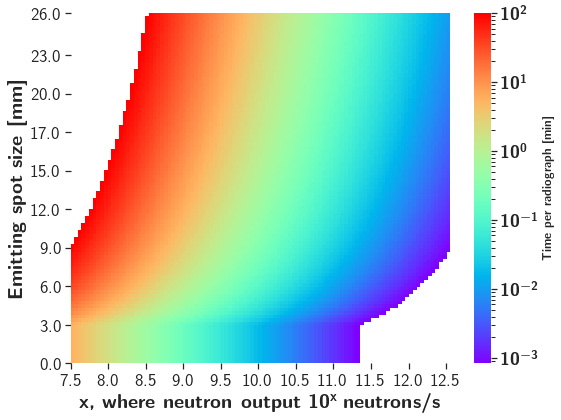

In [14]:
outfile = '/Users/hkromer/polybox/Thesis/Chapters/Introduction/Figures/emitting_spot_output_imaging_time/emitting_spot_output_imaging_time.pdf'

do_run_thesis(outfile,run=row['run'],
        d_so_min=row['d_so_min'], # source object minimum distance, mm
        d_sd_min=row['d_sd_min'], # source detector minimum distance, mm
        d_od_min=row['d_od_min'], # object detector minimum distance, mm
        d_sd_max=row['d_sd_max'], # source detector maximum distance, mm
        d_so_max=row['d_so_max'], # source object maximum distance, mm
        FOV_min=row['FOV_min'], # field of view (degree) required to be satisfied, mm, max size the object can have in the cone
        det_size_max=row['det_size_max'], # maximum detector size, mm lenght of the detector
        B_d=row['B_d'], # assumed detector resolution, mm
        resolution_goal=row['resolution_goal'], # target overall maximum allowed resolution, mm
        detector_efficiency=row['detector_efficiency'], # assumed detector efficiency, [-]
        detector_counts=row['detector_counts'], # required flat field counts per pixel for an image, [-]
        output_bias=output_bias)

In [ ]:
def each_row(row):
    do_run(run=row['run'],
        d_so_min=row['d_so_min'], # source object minimum distance, mm
        d_sd_min=row['d_sd_min'], # source detector minimum distance, mm
        d_od_min=row['d_od_min'], # object detector minimum distance, mm
        d_sd_max=row['d_sd_max'], # source detector maximum distance, mm
        d_so_max=row['d_so_max'], # source object maximum distance, mm
        FOV_min=row['FOV_min'], # field of view (degree) required to be satisfied, mm, max size the object can have in the cone
        det_size_max=row['det_size_max'], # maximum detector size, mm lenght of the detector
        B_d=row['B_d'], # assumed detector resolution, mm
        resolution_goal=row['resolution_goal'], # target overall maximum allowed resolution, mm
        detector_efficiency=row['detector_efficiency'], # assumed detector efficiency, [-]
        detector_counts=row['detector_counts'], # required flat field counts per pixel for an image, [-]
        output_bias=output_bias)
    print(f'Doing run {row.run}')
    
df_runs.apply(lambda x: each_row(x), axis=1)